In [1]:
from epics import PV

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
prefix = '100idWYM'
motor_list = ['m1', 'm2', 'm3', 'm4', 'm5']
pv_list = [':'.join([prefix,motor]) for motor in motor_list]

In [4]:
motors = [PV(motor_pv) for motor_pv in pv_list]

### AD NDSA/pyepics notes

pyepics callback on Acquire attr

attr = ['Acquire','ImageMode','NumImages', 'NDimensions', 'AppendMode', 'CallbackMode','NewArray,'ArrayComplete']

read-only: ImageMode, NumImages,  

read-write: Acquire, NDimensions (and array size?),

write: NewArray, ArrayComplete (would this be after each image in multiple/continuous or after all are complete?)

constants: AppendMode (should be disabled)
	   CallbackMode (either on update or on complete)

In [5]:
from epics.device import Device

class AD_NDSA(Device):
    """
    Basic AreaDetector Camera Device
    """
    attrs = ("Acquire", "AcquirePeriod", "AcquirePeriod_RBV",
             "AcquireTime", "AcquireTime_RBV",
             "ArrayCallbacks", "ArrayCallbacks_RBV",
             "ArrayComplete",
             "ArrayCounter", "ArrayCounter_RBV", "ArrayRate_RBV",
             "ArraySizeX_RBV", "ArraySizeY_RBV", "ArraySize_RBV",
             "AppendMode",
             "BinX", "BinX_RBV", "BinY", "BinY_RBV",
             "CallbackMode",
             "ColorMode", "ColorMode_RBV",
             "DataType", "DataType_RBV", "DetectorState_RBV",
             "Dimensions",
             "Gain", "Gain_RBV", "ImageMode", "ImageMode_RBV",
             "MaxSizeX_RBV", "MaxSizeY_RBV",
             "MinX", "MinX_RBV", "MinY", "MinY_RBV", 
             "NewArray", "NDimensions",
             "NumImages", "NumImagesCounter_RBV", "NumImages_RBV",
             "SizeX", "SizeX_RBV", "SizeY", "SizeY_RBV",
             "TimeRemaining_RBV",
             "TriggerMode", "TriggerMode_RBV", "TriggerSoftware")


    _nonpvs = ('_prefix', '_pvs', '_delim')

    def __init__(self, prefix):
        Device.__init__(self, prefix, delim='', mutable=False,
                              attrs=self.attrs)

    def ensure_value(self, attr, value, wait=False):
        """ensures that an attribute with an associated _RBV value is
        set to the specifed value
        """
        rbv_attr = "%s_RBV" % attr
        if rbv_attr not in self._pvs:
            return self._pvs[attr].put(value, wait=wait)

        if  self._pvs[rbv_attr].get(as_string=True) != value:
            self._pvs[attr].put(value, wait=wait)

In [6]:
ndsa = AD_NDSA("100idWYM:ndsa:cam1:")

In [7]:
xSize = 1001
ySize = 1001

In [8]:
ndsa.put("NDimensions", 2)
ndsa.put("Dimensions", [xSize,ySize])

1

In [9]:
def triggered(pvname = None, value = None, **kw):
    if value == 0:
        print('Acquisition stopped')
    elif value == 1:
        print('Acquistion started')
    else:
        print('Acquisition state indeterminate')
        

In [10]:
ndsa.add_callback('Acquire',triggered)

1

Acquistion started
Acquisition stopped


In [11]:
ndsa.remove_callbacks("Acquire", index = 1)

In [12]:
def gaus2d(x, y, mx=0, my=0, sx=1, sy=1, scale = 1):
    return scale * 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
    
    
def gausImage(size_x = 1000, size_y = 1000, num = 1001, 
              x_center = 600, y_center = 300, 
              x_sigma = 100,  y_sigma = 300,
             scale = 1):

    x = np.linspace(0,size_x, num = num)
    y = np.linspace(0,size_y, num = num)
  
    x, y = np.meshgrid(x, y) # get 2D variables instead of 1D

    return gaus2d(x, y, mx=x_center, my=y_center, sx=x_sigma, sy=y_sigma, scale = scale)

In [13]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [14]:
img = gausImage(x_center = 500, y_center = 500, scale = 1e7)

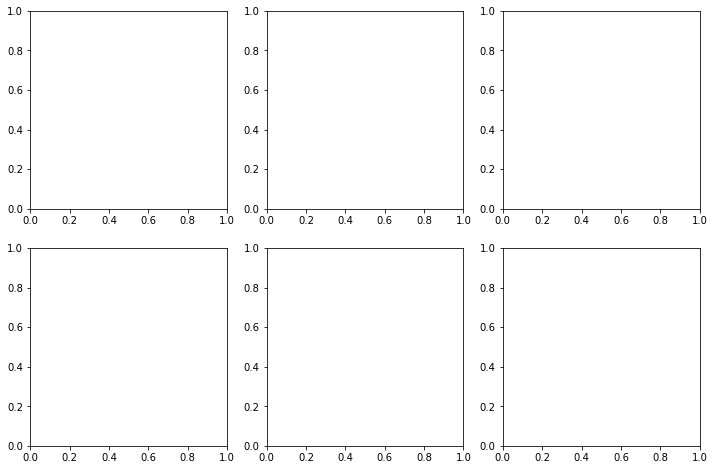

In [15]:
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis','hot']

fig, axs = plt.subplots(2,3, figsize = (12,8))
ax_flat = axs.flatten()

In [16]:
for ax, cmap in zip(ax_flat, cmaps):
    print(cmap)
    print(img.shape)
    ax.imshow(img, cmap = cmap)
    ax.set_title(cmap)

viridis
(1001, 1001)
plasma
(1001, 1001)
inferno
(1001, 1001)
magma
(1001, 1001)
cividis
(1001, 1001)
hot
(1001, 1001)


In [17]:
imgf = img.astype(int)
print(np.max(imgf))

53


In [18]:
# Manually set acquire
ndsa.put("Acquire", 1)
ndsa.put("NewArray", 1)

# Manually stuff array into ArrayIn
ndsa.put("ArrayIn", imgf.flatten())

# Do I need to set sizes beforehand?
ndsa.put("Acquire", 0)
ndsa.put("ArrayComplete", 1)



1

In [37]:
img.shape

(1001, 1001)

In [38]:
imgf.flatten().shape

(1002001,)

In [117]:
np.max(img)

53.05164769729845

Acquisition started
Acquisition stopped


In [19]:
import random

In [20]:
random.randint(200,500)

395

In [21]:
def produce_image(pvname = None, value = None, **kw):
    if value == 0:
        print('Acquisition stopped')
    elif value == 1:
        print('Acquisition started')
        
        # put in single mode (TODO workout multiple and continuous later)
        # ndsa.put("ImageMode", 0)
        
        # set new array to 1
        ndsa.put('NewArray', 1)
        
        # call function for creating image array -- for now just singles
        # image = surrogateBL()
        # flattend_image = image.flatten?
        img = gausImage(x_center = random.randint(700,800), y_center = random.randint(300,400), scale = 1e7)
        imgf = img.astype(int)
        
        # put array in ndsa:ArrayIn
        ndsa.put('ArrayIn', imgf.flatten())        
        
        # set array complete to 1
        ndsa.put('ArrayComplete', 1)
        
        # end acquisition
        ndsa.put('Acquire', 0)
        
       
        
        print('Acquisition complete')
    else:
        print('Acquisition state indeterminate')

In [22]:
ndsa.add_callback('Acquire',produce_image)

1

Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped
Acquisition started
Acquisition complete
Acquisition stopped


In [23]:
ndsa.remove_callbacks("Acquire", index = 1)

In [24]:
motors

[<PV '100idWYM:m1', count=1, type=time_double, access=read/write>,
 <PV '100idWYM:m2', count=1, type=time_double, access=read/write>,
 <PV '100idWYM:m3', count=1, type=time_double, access=read/write>,
 <PV '100idWYM:m4', count=1, type=time_double, access=read/write>,
 <PV '100idWYM:m5', count=1, type=time_double, access=read/write>]

In [25]:
for m in motors:
    print(m.get())

0.0
10.0
0.0
20.0
10.0


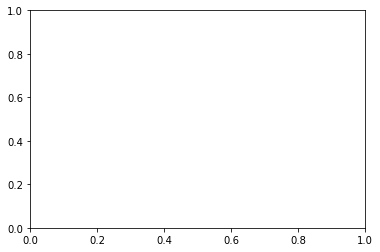

In [26]:
# motors defined earlier

figLive, ax = plt.subplots(1,1)

def simulated_image():
    pos = [m.get() for m in motors]
        
    x_pos = (pos[0]+100)/200*1000
    y_pos = (pos[1]+100)/200*1000
    # smallest beam at m3 = 0    
    x_width = (((pos[2]/100)**2)+0.1)*150+200
    # smallest beam at m4 = 0
    y_width = (((pos[3]/100)**2)+0.1)*250+400
    # max intensity at m5 = 0
    z = (1-((pos[4]/100)**2))*250*2*np.pi*x_width*y_width
    
    img = gausImage(x_center = x_pos, y_center = y_pos, scale = z, x_sigma = x_width, y_sigma=y_width)

    return img


def simulated_acquire(pvname = None, value = None, **kw):
    if value == 0:
        print('Acquisition stopped')
    elif value == 1:
        print('Acquisition started')
        
        # put in single mode (TODO workout multiple and continuous later)
        # ndsa.put("ImageMode", 0)
        
        # set new array to 1
        ndsa.put('NewArray', 1)
        
        # call function for creating image array -- for now just singles
       
        img = simulated_image()
        print("Image Triggered")
        imgf = img.astype(int)
        
        # put array in ndsa:ArrayIn
        ndsa.put('ArrayIn', imgf.flatten())        
        print("Image Acquired")
        # set array complete to 1
        ndsa.put('ArrayComplete', 1)
        
        # end acquisition
        ndsa.put('Acquire', 0)
        
        ax.imshow(img, cmap = 'viridis')
        ax.set_title("Image # " + str(ndsa.get("ArrayCounter_RBV")))
       
        
        print('Acquisition complete')
    else:
        print('Acquisition state indeterminate')
        


In [27]:
ndsa.add_callback('Acquire',simulated_acquire)

1

Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped


CA.Client.Exception...............................................
    Context: "ravioli.xray.aps.anl.gov:5064"
    Source File: ../cac.cpp line 1237
    Current Time: Thu Apr 14 2022 14:09:33.681392496
..................................................................


Acquisition stopped


In [48]:
ndsa.remove_callbacks("Acquire", index = 1)

In [17]:
ndsa.add_callback('Acquire',simulated_acquire)

2

In [40]:
ndsa.put("DataType","UInt8")

1

Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisition stopped
Acquisition started
Image Triggered
Image Acquired
Acquisition complete
Acquisit